# Time Series Analysis and Forecasting

RUNNING TO-DO LIST: fix up the plots using bokeh. Finish markdown write-ups in TS decomp.

In [2]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

We are going to use US monthly birth numbers for forecasting purposes. <br>
Some useful links:
* Time Series cross validation: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* Time Series decomposition: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* Time Series (ETS) tutorial: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
* Time Series (ARMA) overview: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#LinearModels
* ARIMA tutorial: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

## 1. Load and Prep Data

In [3]:
# importing data
birth = pd.read_table('data/birth.txt')
# checking
birth.head()

num_births
0         295
1         286
2         300
3         278
4         272

In [5]:
# creating a dates variable (from January 1980 and ending December 2010).
dates = pd.date_range(start='1/1/1980', end='12/31/2010', freq='M')

In [6]:
# setting the dates variable as the index of your dataframe
birth = birth.set_index(dates)
birth.head()

num_births
1980-01-31         295
1980-02-29         286
1980-03-31         300
1980-04-30         278
1980-05-31         272

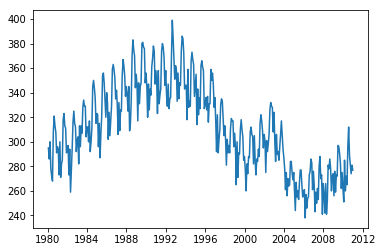

In [7]:
plt.plot(birth)

## 2. Split into Train-Test

Time series data cannot be evaluated using traditional cross validation methods. That leaves us with two options: (1) Splitting the data manually using a certain point in time as our division line between 'past' observations (the training set) and 'future' values (the testing set we can measure our forecasts against). (2) Splitting data into multiple training/testing folds using TimeSeriesSplit from the sklearn library.

Observations: 372
Training Observations: 245
Testing Observations: 127


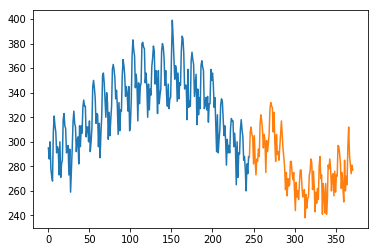

In [8]:
# splitting into training and testing sets using 66-34
X = birth.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# then plotting it using different colors
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

In [9]:
# made train_df and test_df (the latter to be used later)
train_df = birth[0:245]
train_df.head()
test_df = birth[245:372]

Observations: 186
Training Observations: 93
Testing Observations: 93
Observations: 279
Training Observations: 186
Testing Observations: 93
Observations: 372
Training Observations: 279
Testing Observations: 93


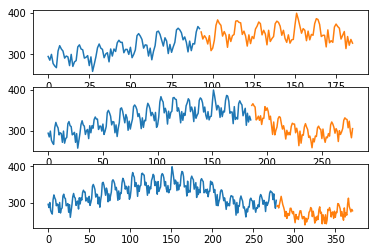

In [13]:
# ALTERNATIVE
# splitting into three training sets using sklearn TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
X = birth.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1

# then printing size of each and plotting each separately
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

## 3. Forecasting Metrics

scale dependent errors (comparing forecast methods on a single data set / cannot be used to make comparisons between series that are on different scales): <br>
MD (mean deviation) $\frac{A_t-F_t}{n}$ <br>
MAD (also called MAE): $\frac{|A_t-F_t|}{n}$ <br>
MSE (mean squared error): $\frac{(A_t-F_t)^2}{n}$ <br>
RMSE (root mean squared error): $\sqrt{\frac{(A_t-F_t)^2}{n}}$ <br>
percentage errors (used to compare forecast performance between different data sets):
MPE, MAPE <br>
also scaled errors

## 4. Time Series Decomposition

can have trend, seasonal, residual <br>
$y_t = T_t+ S_t+\epsilon_t$ <br>
can be additive or multiplicative (can use different forecasting methods accordingly) <br>

statsmodel has a seasonal_decompose() function, it will show observed, can call trend, seasonal, and residual <br>
print(result.trend) <br>
print(result.seasonal) <br>
print(result.resid) <br>
print(result.observed) <br>

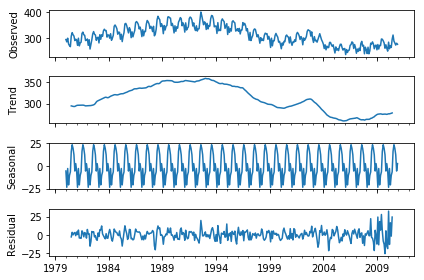

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_a = seasonal_decompose(series, model='additive')
result_a.plot()
plt.show()

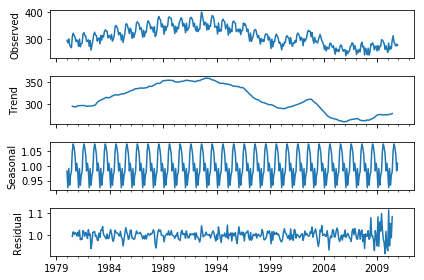

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_m = seasonal_decompose(series, model='multiplicative')
result_m.plot()
plt.show()

Note that the various components are on different scale. The trend is roughly on the same scale as the observations, but seasonal fluctuations and residuals are on a different scale. Talk about error distributions. Maybe look at QQ-plots? These are very bad--shows that classical decomposition is not powerful enough to capture whatever was happening starting 2008.

<function matplotlib.pyplot.show>

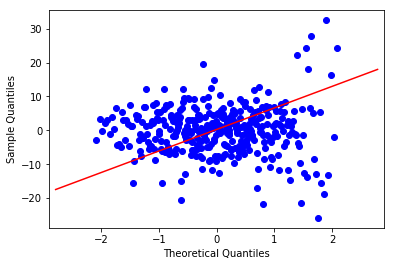

In [16]:
import statsmodels.api as sm
import scipy.stats as stats
fig = sm.qqplot(result_a.resid, line='q')
plt.show

<function matplotlib.pyplot.show>

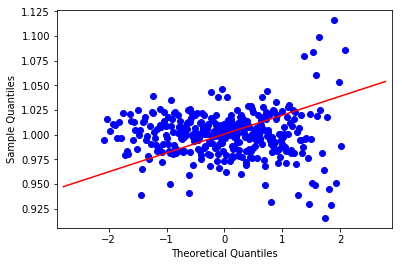

In [17]:
import statsmodels.api as sm
import scipy.stats as stats
fig = sm.qqplot(result_m.resid, line='q')
plt.show

## 5.1. Forecasting Methods: Simple Models

naive - "only yesterday matters" <br>
$\hat{y_{t+1}}=x_t$

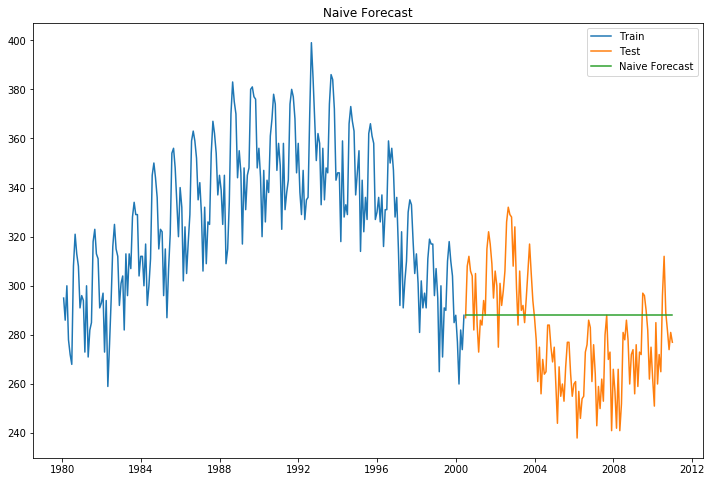

In [14]:
dd= np.asarray(train_df.num_births)
y_hat = test_df.copy()
y_hat['naive'] = dd[len(dd)-1] # this line of code is for one-time forecast
plt.figure(figsize=(12,8))
plt.plot(train_df.index, train_df['num_births'], label='Train')
plt.plot(test_df.index,test_df['num_births'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat.naive))
print(rms)

22.962139328026147


cumulative - "everything matters" <br>
$\hat{y_{t+1}}=\frac{\sum_{i=1}^{t}x_i}{t}$

moving average - select how much matters <br>
$\hat{y_{t+1}}=\frac{\sum_{i=t+1-M}^{t}x_i}{M}$

for python implementations, see Methods 1-3 in https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/ <br>
note that $\hat{y}$ depends on forecasting horizon -- here we forecast once after we trained our model on our data

## 5.2. Forecasting Methods: Exponential Smoothing

Exponential Smoothing uses trend and seasonality. It is a whole taxonomy of models. For more detail and ARIMA-ETS equivalences, see here: https://www.otexts.org/fpp/7/6

In [16]:
import pandas as pd
df = pd.read_excel('images/forecasting_methods.xlsx')
df.head()

Seasonality: none  \
Trend: none                   Simple exponential smoothing   
Trend: additive                                       Holt   
Trend: additive damped                         Holt-damped   
Trend: multiplicative                                    0   
Trend: multiplicative damped                             0   

                              Seasonality: additive  \
Trend: none                                       0   
Trend: additive                                   0   
Trend: additive damped                            0   
Trend: multiplicative                             0   
Trend: multiplicative damped                      0   

                               Seasonality: multiplicative  
Trend: none                   Double exponential smoothing  
Trend: additive                                Holt-Winter  
Trend: additive damped                                   0  
Trend: multiplicative                                    0  
Trend: multiplicative damped                             0

Parameters:	
* endog (array-like) – Time series
* trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.
* seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.
* seasonal_periods (int, optional) – The number of seasons to consider for the holt winters.

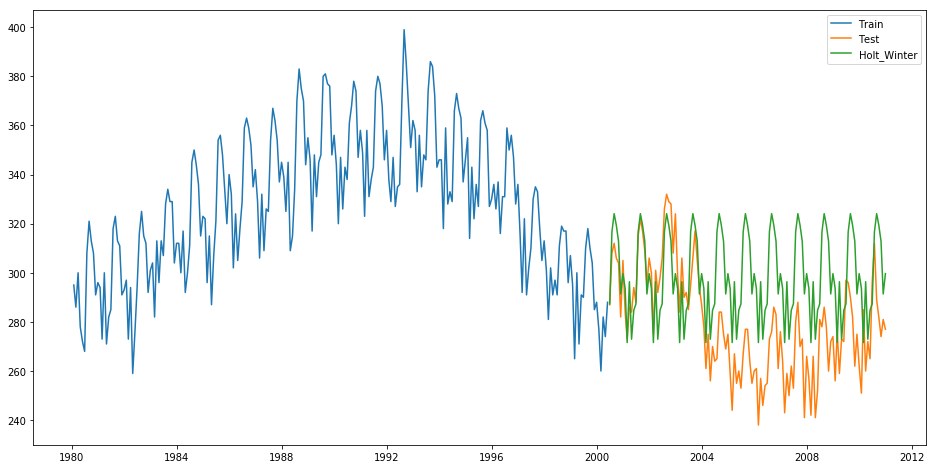

In [17]:
# here we have trend and seasonality, so we will use Holt-Winters
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test_df.copy()
fit1 = ExponentialSmoothing(np.asarray(train_df['num_births']), seasonal_periods=12, trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_df))
plt.figure(figsize=(16,8))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt_Winter))
print(rms)

27.223522095250733


## 5.3. Forecasting Methods: ARIMA

ARIMA uses autocorrelation. If a time series is stationary (see concept below), the correlation between two $y$'s only depends on the lag between them. These correlations between a time series and a lagged version of itself are called autocorrelations. Some exponential smoothing models have ARIMA equivalents and vica versa. (This book gives you the ARIMA-ETS equivalences: https://www.otexts.org/fpp/7/6)

### Stationarity

Image courtesy of www.seanabu.com) <br>

![test](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=1500w)

To test for stationarity: use Augmented Dickey-Fuller test (hypothesis test)<br>
$H_0$: time series is not stationary. <br>
$H_a$: time series is stationary

In [25]:
test=sm.tsa.stattools.adfuller(train_df['num_births'])
print("ADF p-value for training series: {0:2.2f}".format(test[1]))

ADF p-value for training series: 0.71


### ARIMA Components

A non-seasonal ARIMA model: combines differencing with autoregression and a moving average model
* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. <br>

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

### (1) Differencing

In [53]:
# differencing: computing the differences between t and t-1 observations
train_df_diff = train_df['num_births'].diff()[1:]

# running ADF test to see if it made a difference
test = sm.tsa.stattools.adfuller(train_df_diff)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

ADF p-value for differenced training series: 0.06


1980-02-29    -9.0
1980-03-31    14.0
1980-04-30   -22.0
1980-05-31    -6.0
1980-06-30    -4.0
Freq: M, Name: num_births, dtype: float64

In [54]:
# let's do it again!
train_df_diff2 = train_df_diff.diff()[1:]

# running ADF test to see if it made a difference
test = sm.tsa.stattools.adfuller(train_df_diff2)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

ADF p-value for differenced training series: 0.00


### (2) Moving Average Modeling

$X_t=\mu+\epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q} = \displaystyle\sum_{i=1}^{q} \theta_i\epsilon_{t-i} +\mu$ <br>

$\epsilon_t$: noise <br>
$\theta_1\epsilon_{t-1}$: yesterday's noise <br>
$\theta_q\epsilon_{t-q}$: noise from $q$ days ago <br>
moving average models are always stationary <br>
how do I get $q$? I plot autocorrelation -- if it is a MA(q) model, it drops off at $q$ <br>
how do I get $\theta$? regression gives me the coefficients

In [44]:
# moving average MA modeling
from statsmodels.tsa.arima_model import ARIMA
series = train_df

# fit model
model = ARIMA(series, order=(0,0,1)) #the third parameter is the MA order (q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             num_births   No. Observations:                  245
Model:                     ARMA(0, 1)   Log Likelihood               -1109.624
Method:                       css-mle   S.D. of innovations             22.405
Date:                Tue, 22 May 2018   AIC                           2225.249
Time:                        14:28:21   BIC                           2235.752
Sample:                    01-31-1980   HQIC                          2229.478
                         - 05-31-2000                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              327.3796      2.262    144.740      0.000     322.947     331.813
ma.L1.num_births     0.5825      0.041     14.138      0.000       0.502       0.663
                            

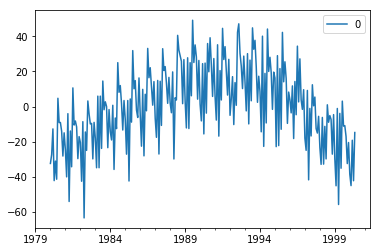

In [45]:
# let's plot the residuals
# line plot of residual errors
# (suggests that there is still trend & seasonality not captured by the model)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

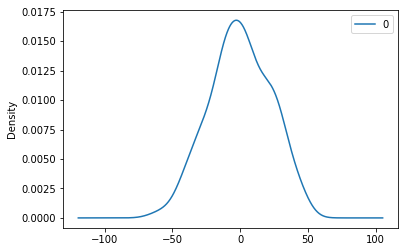

In [46]:
# density plot of residual errors
#(suggests the errors are not quite Gaussian, but are centered on zero)
residuals.plot(kind='kde')

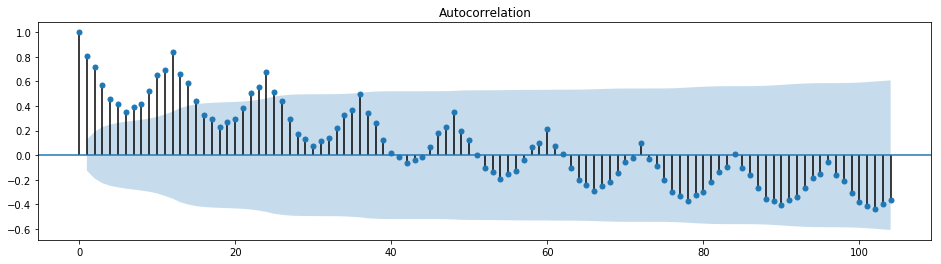

In [47]:
# to see how many time periods to pick: plot autocorrelation and see where it drops off
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(series, lags=2*52, ax=ax)

### (3) Autoregressive Modeling

$X_t=\epsilon_t+\phi_1 X_{t-1}+...+\phi_p X_{t-p} = \displaystyle\sum_{i=1}^{p} \phi_iX_{t-i} +\epsilon_t$ <br>
$\phi_1 X_{t-1}$: yesterday's value <br>
$phi_p X_{t-p}$: value $p$ days ago
autoregressive models aren't always stationary (depends on $\phi$ parameter) <br>
how do I get $p$? autocorrelation always has exponential decay, so that doesn't help <br>
I plot partial autocorrelation -- if it is an AR(p) model, it drops off at $p$ <br>
how do I get $\phi$? regression gives me the coefficients

/Users/andreafabry/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


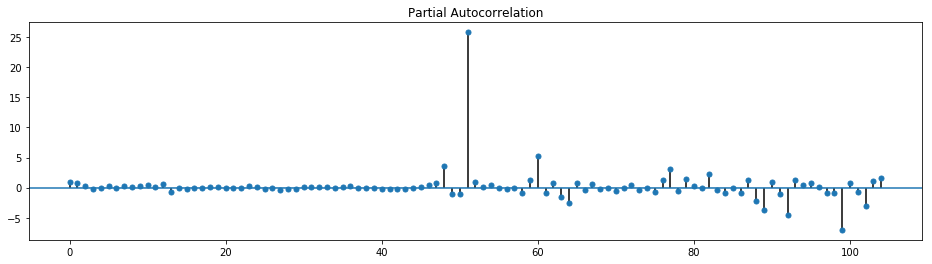

In [50]:
# autoregression AR modeling
# to see how many time periods to pick: plot autocorrelation and see where it drops off
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(series, lags=2*52, ax=ax)

ARIMA - you take a difference until you get an ARMA model <br>
$Y_t = \nabla^d X_t$ <br>
$X_t$: ARIMA model <br>
$\nabla^d$ differenced $d$ times <br>
creating $Y_t$ ARMA model <br>
$Y_t = \mu+\phi_1 Y_{t-1}+...+\phi_p Y_{t-p}+\epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q}$

Steps to ARIMA:
1. Visualize
2. Stationarize (check with Dickey-Fuller)
3. Find optimal parameters to p,d,q with ACF and PACF plots
4. Build ARIMA model
5. Predict and score

#### 1. Visualize

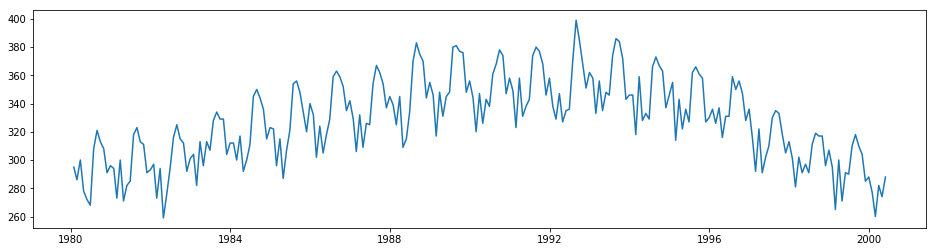

In [19]:
# visualize
plt.figure(figsize=(16,4))
plt.plot(train_df)

#### 2. Stationarize

In [42]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12, center=False).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

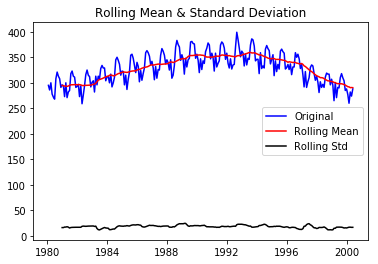

Results of Dickey-Fuller Test:
Test Statistic                  -1.102790
p-value                          0.713958
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [46]:
test_stationarity(train_df['num_births'])

In [ ]:
# variation in std is very small but the mean varies over time (trend)

#### option A: log (trend), then differencing (seasonal)

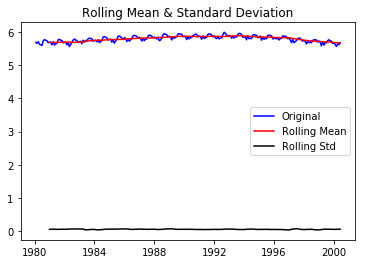

Results of Dickey-Fuller Test:
Test Statistic                  -1.064933
p-value                          0.728852
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [48]:
# let's remove the trend by taking a log
train_log = np.log(train_df)

# now let's see
test_stationarity(train_log['num_births'])

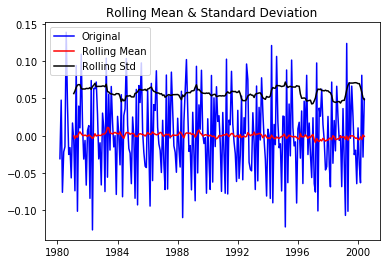

Results of Dickey-Fuller Test:
Test Statistic                  -2.791613
p-value                          0.059482
#Lags Used                      15.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [50]:
# now let's deal with seasonality
train_log_diff = train_log - train_log.shift()
train_log_diff.dropna(inplace=True)

# see the result
test_stationarity(train_log_diff['num_births'])

#### Option B: log (trend), then seasonal_decompose() (seasonal)

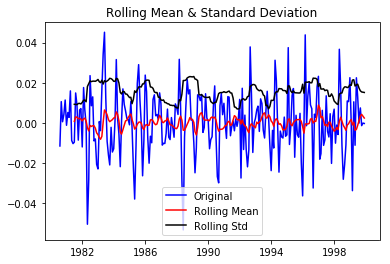

Results of Dickey-Fuller Test:
Test Statistic                -8.480178e+00
p-value                        1.400030e-13
#Lags Used                     7.000000e+00
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64


In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
train_log_decompose = residual
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose['num_births'])

#### 3. Find optimal parameters to p,d,q with ACF and PACF plots

In [56]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff, nlags=20)
lag_pacf = pacf(train_log_diff, nlags=20, method='ols')

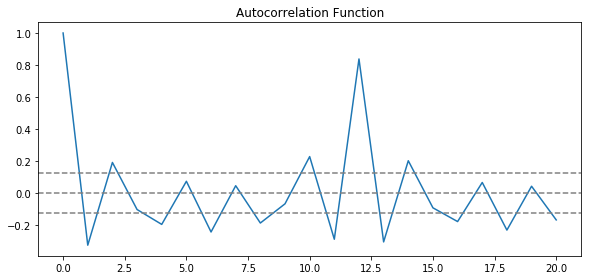

In [57]:
# plot ACF: 
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()

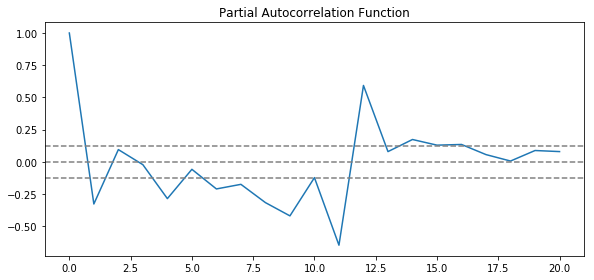

In [58]:
# plot PACF:
plt.figure(figsize=(16,4))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
# so we have p=1, d=1, amd q=1 (or 0? let's try both)

In [59]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  

In [60]:
# take back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

1980-02-29   -0.000112
1980-03-31    0.010111
1980-04-30   -0.016951
1980-05-31    0.026692
1980-06-30    0.001303
Freq: M, dtype: float64

In [61]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

1980-02-29   -0.000112
1980-03-31    0.010000
1980-04-30   -0.006952
1980-05-31    0.019741
1980-06-30    0.021044
Freq: M, dtype: float64

In [63]:
predictions_ARIMA_log = pd.Series(train_log.ix[0], index=train_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/Users/andreafabry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


1980-01-31         NaN
1980-02-29   -0.000112
1980-03-31    0.010000
1980-04-30   -0.006952
1980-05-31    0.019741
Freq: M, dtype: float64

Text(0.5,1,'RMSE: nan')

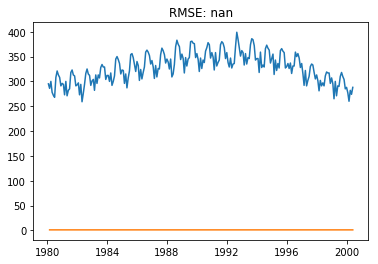

In [65]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(train_df)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-train_df['num_births'])**2)/len(train_df)))

In [24]:
# fit model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.num_births   No. Observations:                  244
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1027.817
Method:                       css-mle   S.D. of innovations             16.321
Date:                Fri, 25 May 2018   AIC                           2069.634
Time:                        12:23:53   BIC                           2094.114
Sample:                    02-29-1980   HQIC                          2079.493
                         - 05-31-2000                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0208      0.641     -0.032      0.974      -1.276       1.235
ar.L1.D.num_births    -0.2903      0.064     -4.549      0.000      -0.415      -0.165
ar.L2.D.num_births  

In [ ]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(5, 1, 0),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

## 5.4. Forecasting Methods: Causality & Patterns

Dynamic regression: regression model with ARIMA errors

$Y_t=\beta_0 + Y_{t-1}\beta_1 + Y_{t-2}\beta_2 + ... + Y_{t-n}\beta_n + \epsilon$ <br>
reimagine the residual error $\epsilon$ from the regression equation as an ARIMA model, apply ARIMA until the error from the ARMA model is just white noise. 

This is the algorithm:
1. Check that the forecast variable and all predictors are stationary. If not, apply differencing until all variables are stationary. Where appropriate, use the same differencing for all variables to preserve interpretability.
2. Fit the regression model with AR(2) errors for non-seasonal data or ARIMA$(2,0,0)(1,0,0)_m$ errors for seasonal data.
3. Calculate the errors ($n_t$) from the fitted regression model and identify an appropriate ARMA model for them.
4. Re-fit the entire model using the new ARMA model for the errors.
5. Check that the $e_t$ series looks like white noise.